# Computational -- HW4 -- Mahan Mirza Khanlari

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
np.random.seed(0)
%matplotlib inline
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.family'] = 'serif'
plt.rcParams['mathtext.fontset'] = 'dejavuserif'
plt.rcParams['xtick.direction']= 'in'
plt.rcParams['ytick.direction']= 'in'

# Problem 2 
### (Just for the context of other problems)
write a very simple MH MCMC sampler. Sample in a single parameter x and give the sampler as its density function p(x) a Gaussian density with mean 2 and variance 2. (Note that variance is the square of the standard deviation.) Give the sampler a proposal distribution q(x 0 | x) a Gaussian pdf for x 0 with mean x and variance 1. Initialize the sampler with x = 0 and run the sampler for more than 104 steps. Plot the results as a histogram, with the true density over-plotted sensibly. 

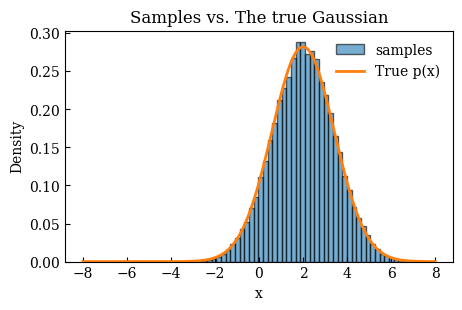

In [2]:
#we did this in class, but for the context I'm gonna put it here
def gaussian(x, mu=2.0, var=2.0):
    """
      p(x) = (1 / sqrt(2pi var)) * exp[-(x - mu)^2 / (2 var)]
    """
    coeff = 1.0 / np.sqrt(2 * np.pi * var)
    exponent = -0.5 * (x - mu)**2 / var
    return coeff * np.exp(exponent)


def mh_sampler(n_steps, proposal_var=1.0, initial_x=0.0, mu=2.0, var=2.0):
    """
    Runs a basic MH sampler:
    Start at x = initial_x, at each step propose x', accept with prob min(1, p(x')/p(x))
    Returns an array of length n_steps.
    """
    chain = np.empty(n_steps)
    x = initial_x
    for i in range(n_steps):
        #Propose a new point
        x_prop = np.random.normal(loc=x, scale=np.sqrt(proposal_var))
        #Compute acceptance ratio
        #alpha = p(x_prop) / p(x)
        alpha = gaussian(x_prop, mu, var) / gaussian(x, mu, var)
        alpha = min(1.0, alpha)
        #Accept or reject
        if np.random.rand() < alpha:
            x = x_prop
        chain[i] = x
    return chain

n_steps = 100000 #10^5 steps
chain = mh_sampler(n_steps, proposal_var=1.0, initial_x=0.0)
x_vals = np.linspace(-8, 8, 200)

plt.figure(figsize=(5,3))
plt.hist(chain, bins=50, density=True, alpha=0.6, edgecolor='k',label="samples")
plt.plot(x_vals, gaussian(x_vals), lw=2, label="True p(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Samples vs. The true Gaussian")
plt.legend(frameon=False)
plt.show()

# Problem 3

Modify the sampler you wrote in Problem 2 to take steps not in x but in ln x. That is, replace the Gaussian proposal distribution q(x 0 | x) with a Gaussian distribution in ln x q(ln x 0 | ln x), but make no other changes. By doing this, you are no longer sampling the Gaussian p(x) that you were in Problem 2. What about your answers change? What distribution are you sampling now? Compute the analytic function that you have sampled from – this will no longer be the same p(x) – and over-plot it on your histogram.

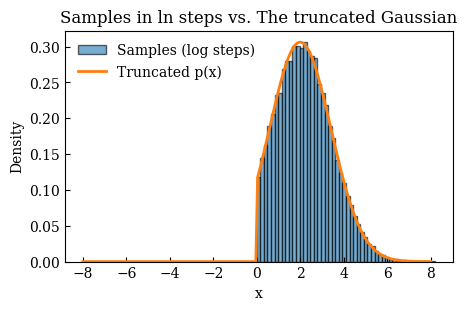

In [3]:
# Now we propose in log-space

def mh_sampler_ln(n_steps, proposal_var=1.0, initial_x=1.0, mu=2.0, var=2.0):
    """
    Runs a MH sampler that proposes moves in ln(x):
    ln x_prop ~ N(ln x, proposal_var)
    Acceptance ratio includes an extra factor of (x_prop / x) (explained in the function.) 
    """
    chain = np.empty(n_steps)
    x = initial_x
    for i in range(n_steps):
        #Propose in log-space
        ln_x_prop = np.random.normal(loc=np.log(x), scale=np.sqrt(proposal_var))
        x_prop = np.exp(ln_x_prop)
        #Compute acceptance ratio:
        #We multiply alpha by the ratio by the jacobian since we're transforming to y=ln(x)
        #dx/dy=dx/d(ln(x)) which is just x
        #Same for d(x_prob)/dln(x_prob which is just x_prob
        #alpha = [p(x_prop)/p(x)] * (Jacobian = x_prop/x)
        ratio = (gaussian(x_prop, mu, var)/ gaussian(x, mu, var)) * (x_prop / x)
        alpha = min(1.0, ratio)
        #Accept or reject
        if np.random.rand() < alpha:
            x = x_prop
        chain[i] = x
    return chain


chain_ln = mh_sampler_ln(n_steps, proposal_var=1.0, initial_x=1.0)

def truncated_gaussian(x, mu=2.0, var=2.0):
    """
    This is the gaussian which is cut at x<0
    p(x) = p(x) / phi(mu/sigma) for x > 0, zero otherwise.
    """
    sigma = np.sqrt(var)
    #We need to normalize this by the CDF to make sure p is 1 when integrated over 0 to infinity
    #A test can be removing the /Z and seeing that the sample density would be higher
    Z = norm.cdf(mu/sigma)
    p = gaussian(x, mu, var) / Z
    p[x <= 0] = 0.0 # since we wanna match the sample in log steps and log x<0 is imaginary
    return p

plt.figure(figsize=(5,3))
plt.hist(chain_ln, bins=50, density=True, alpha=0.6, edgecolor='k',label="Samples (log steps)")
x_vals = np.linspace(-8, 8, 200)
plt.plot(x_vals, truncated_gaussian(x_vals), lw=2,label="Truncated p(x)")
plt.xlabel("x")
plt.ylabel("Density")
plt.title("Samples in ln steps vs. The truncated Gaussian")
plt.legend(frameon=False)
plt.show()

Proposing moves in $\ln x$ keeps the Metropolis–Hastings acceptance ratio  

$$
\alpha \;=\; \min\!\left[\,1,\;
   \frac{p(x')}{p(x)} \;\frac{x'}{x}\right],
$$

so the distribution is still Gaussian but truncated to $x>0$.  
The analytic pdf is  

$$
p(x)=
\frac{1}{\Phi(\mu/\sigma)}\,
\frac{1}{\sqrt{2\pi\sigma^{2}}}\,
\exp\!\Bigl[-\tfrac12\bigl(x-\mu\bigr)^{2}/\sigma^{2}\Bigr],
\qquad x>0,
$$

where $\Phi$ is the normal CDF.

# Problem 4

Re-do Problem 2 but now look at convergence: Plot the x chain as a function of timestep. Also split the chain into four contiguous segments (the first, second, third, and fourth quarters of the chain). In each of these four, compute the empirical mean and empirical variance of x. What do you conclude about convergence from these heuristics?

Empirical means by quarter: [2.021127977431211, 1.973412855828534, 2.057930168354993, 2.035712834808809]
Empirical variances by quarter: [2.008051553455719, 1.9961347632921853, 1.9433881650453269, 1.9115930017216975]


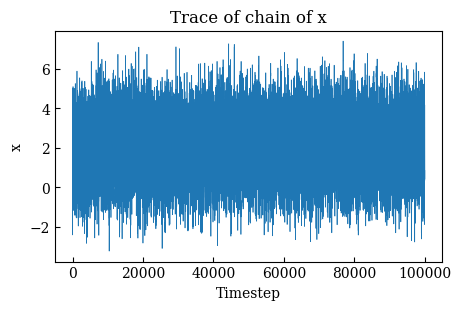

In [4]:
plt.figure(figsize=(5, 3))
plt.plot(chain, linewidth=0.5)
plt.xlabel("Timestep")
plt.ylabel("x")
plt.title("Trace of chain of x")

#This is just a simple split into 4 bins and computing the mean and the variance
quarters = np.array_split(chain, 4)
means_q = [q.mean() for q in quarters]
vars_q = [q.var(ddof=1) for q in quarters]
print("Empirical means by quarter:", means_q)
print("Empirical variances by quarter:", vars_q)

The chain stays in the correct region: The empirical means and variances in the four quarters fluctuate around the analytic values (mean = 2, var = 2) within a small error, indicating that the chain has converged.

# Problem 5

Write a piece of code that computes the empirical autocorrelation function. You will probably want to speed this computation up by using a fast Fourier transform30. Run this on the chain you obtained from Problem 2. Plot the autocorrelation function you find at short lags (∆ < 100). repeat the exercise using a proposal distribution that has a variance two times larger, and again with a variance that is two times smaller than what is given in the original problem. How does the autocorrelation function change (and why)?

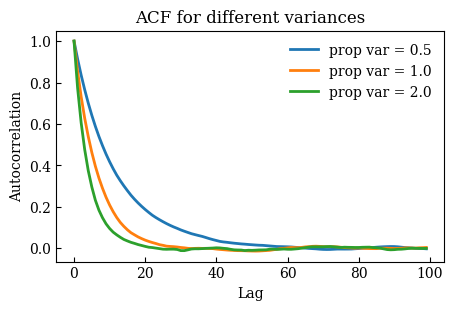

In [5]:
#I couldn't get it to work with fft. I just wrote things from scratch I guess.

def acf(x, lag):
    """
    The autocorrelation function:
    p(k) = [Sum_{t=0 to N−1−k} (x_t−mu)(x_{t+k}−mu)] / [Sum_{t=0 to N−1} (x_t−mu)^2]
    """
    #Compute mean
    N = len(x)
    mu = sum(x) / N
    #Centered data y_t = x_t − mu
    y = [xi - mu for xi in x]
    #Denominator c(0) = sum(y_t^2)
    #Again this c(0) normalizes the correlation
    c0 = sum(yi * yi for yi in y)
    #For each lag k, compute c(k) = sum (y_t * y_{t+k})
    acf = []
    for k in range(lag):
        ck = sum(y[t] * y[t + k] for t in range(N - k))
        acf.append(ck / c0)   #p(k)= c(k)/c(0)
    return acf

lag = 100
props = [0.5, 1.0, 2.0]
chains = {pv: mh_sampler(n_steps, proposal_var=pv, initial_x=0.0)for pv in props}

plt.figure(figsize=(5,3))
for pv, ch in chains.items():
    ac = acf(ch, lag)
    plt.plot(range(lag), ac, label=f"prop var = {pv}")

plt.xlabel("Lag")
plt.ylabel("Autocorrelation")
plt.title("ACF for different variances")
plt.legend(frameon=False)
plt.show()

* Proposal var = 0.5 – high acceptance, but the chain moves slowly → longest ACF tail.  
* Proposal var = 1.0 – a balanced choice it seems. Not too many rejections, but not the slowest
* Proposal var = 2.0 – low acceptance, so many proposed values are rejected, correlation is higher, but once a move is accepted the chain decorrelates fastest.